In [119]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from tqdm import tqdm
import pop_tools

def pop_find_lat_ind(loc, LATDAT):
    return np.abs(LATDAT[:, 0].values - loc).argmin()

def pop_find_lon_ind(loc, LONDAT, direction="w"):
    if direction.lower() in ["east", "e"]:
        value = loc
    elif direction.lower() in ["west", "w"]:
        value = 360 - loc
    else:
        print("I do not know which direction.")
    return np.nanargmin(np.abs(LONDAT[0, :].values - value))

# open sample data
ds = xr.open_dataset(r'D:\CESM_output\pop_tools-test\pop2_test.pop.h.0004-09.nc')

In [120]:
ds.RF_TEND_TEMP

<xarray.DataArray 'RF_TEND_TEMP' (time: 1, z_t: 60, nlat: 384, nlon: 320)>
[7372800 values with dtype=float32]
Coordinates:
  * time     (time) object 0004-10-01 00:00:00
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    ULONG    (nlat, nlon) float64 ...
    ULAT     (nlat, nlon) float64 ...
    TLONG    (nlat, nlon) float64 ...
    TLAT     (nlat, nlon) float64 ...
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Robert Filter Tendency for TEMP
    units:         degC/s
    grid_loc:      3111
    cell_methods:  time: mean

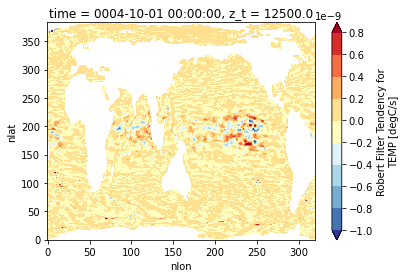

In [121]:
ds.RF_TEND_TEMP.isel(z_t=12).plot(levels=np.arange(-1e-9,1e-9,2e-10),cmap="RdYlBu_r")

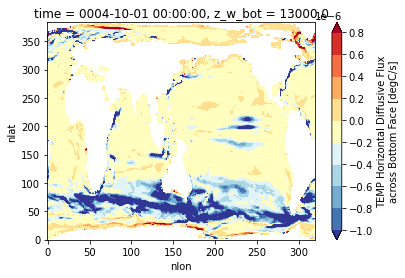

In [122]:
ds.HDIFB_TEMP.isel(z_w_bot=12).plot(levels=np.arange(-1e-6,1e-6,2e-7),cmap="RdYlBu_r")

In [123]:
# get lola inds from somewhere for indexing later on
lola_inds = {}
inds_lat = range(-89, 90, 1)
for j in inds_lat:
    if j < 0:
        lola_inds["j_" + str(j)[1:] + "s"] = pop_find_lat_ind(j, ds.TLAT)
    else:
        lola_inds["j_" + str(j) + "n"] = pop_find_lat_ind(j, ds.TLAT)

inds_lon = range(0, 360, 1)
for i in inds_lon:
    lola_inds["i_" + str(i) + "_w"] = pop_find_lon_ind(i, ds.TLONG)

DZT = np.zeros((60,384,320))

for k in range(60):
            DZT[k,:,:] = ds.dz[k]

ds2 = xr.Dataset({'DZT': (['z_t','nlat','nlon',], DZT),
                   'DZU': (['z_t','nlat','nlon'], DZT)},
                    coords={'TLAT': (['nlat','nlon'],ds.TLAT),
                            'TLONG': (['nlat','nlon'],ds.TLONG),
                            'ULAT': (['nlat','nlon'],ds.ULAT),
                            'ULONG': (['nlat','nlon'],ds.ULONG),
                            'z_t': (['z_t'],ds.z_t)})
ds["DZT"] = ds2.DZT
ds["DZU"] = ds2.DZU

ds.DZT.attrs["long_name"] = "Thickness of T cells"
ds.DZT.attrs["units"] = "centimeter"
ds.DZT.attrs["grid_loc"] = "3111"
ds.DZU.attrs["long_name"] = "Thickness of U cells"
ds.DZU.attrs["units"] = "centimeter"
ds.DZU.attrs["grid_loc"] = "3221"

# make sure we have the cell volumne for calculations
VOL = (ds.DZT * ds.DXT * ds.DYT).compute()
KMT = ds.KMT.compute()

for j in tqdm(range(len(KMT.nlat))):
    for i in range(len(KMT.nlon)):
        k = KMT.values[j, i].astype(int)
        VOL.values[k:, j, i] = 0.0

ds["VOL"] = VOL

ds.VOL.attrs["long_name"] = "volume of T cells"
ds.VOL.attrs["units"] = "centimeter^3"
ds.VOL.attrs["grid_loc"] = "3111"

budget = xr.Dataset()
metrics = {
    ("X",): ["DXU", "DXT"],  # X distances
    ("Y",): ["DYU", "DYT"],  # Y distances
    ("Z",): ["DZU", "DZT"],  # Z distances
    ("X", "Y"): ["UAREA", "TAREA"],
}

100%|██████████| 384/384 [00:00<00:00, 1139.04it/s]


In [124]:
ds.DZT

<xarray.DataArray 'DZT' (z_t: 60, nlat: 384, nlon: 320)>
array([[[ 1000.        ,  1000.        ,  1000.        , ...,
          1000.        ,  1000.        ,  1000.        ],
        [ 1000.        ,  1000.        ,  1000.        , ...,
          1000.        ,  1000.        ,  1000.        ],
        [ 1000.        ,  1000.        ,  1000.        , ...,
          1000.        ,  1000.        ,  1000.        ],
        ...,
        [ 1000.        ,  1000.        ,  1000.        , ...,
          1000.        ,  1000.        ,  1000.        ],
        [ 1000.        ,  1000.        ,  1000.        , ...,
          1000.        ,  1000.        ,  1000.        ],
        [ 1000.        ,  1000.        ,  1000.        , ...,
          1000.        ,  1000.        ,  1000.        ]],

       [[ 1000.        ,  1000.        ,  1000.        , ...,
          1000.        ,  1000.        ,  1000.        ],
        [ 1000.        ,  1000.        ,  1000.        , ...,
          1000.        ,  1000.        ,  1000.        ],
        [ 1000.        ,  1000.        ,  1000.        , ...,
          1000.        ,  1000.        ,  1000.        ],
...
        [24996.24414062, 24996.24414062, 24996.24414062, ...,
         24996.24414062, 24996.24414062, 24996.24414062],
        [24996.24414062, 24996.24414062, 24996.24414062, ...,
         24996.24414062, 24996.24414062, 24996.24414062],
        [24996.24414062, 24996.24414062, 24996.24414062, ...,
         24996.24414062, 24996.24414062, 24996.24414062]],

       [[24998.109375  , 24998.109375  , 24998.109375  , ...,
         24998.109375  , 24998.109375  , 24998.109375  ],
        [24998.109375  , 24998.109375  , 24998.109375  , ...,
         24998.109375  , 24998.109375  , 24998.109375  ],
        [24998.109375  , 24998.109375  , 24998.109375  , ...,
         24998.109375  , 24998.109375  , 24998.109375  ],
        ...,
        [24998.109375  , 24998.109375  , 24998.109375  , ...,
         24998.109375  , 24998.109375  , 24998.109375  ],
        [24998.109375  , 24998.109375  , 24998.109375  , ...,
         24998.109375  , 24998.109375  , 24998.109375  ],
        [24998.109375  , 24998.109375  , 24998.109375  , ...,
         24998.109375  , 24998.109375  , 24998.109375  ]]])
Coordinates:
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    ULONG    (nlat, nlon) float64 321.1 322.3 323.4 324.5 ... 319.2 319.6 320.0
    ULAT     (nlat, nlon) float64 -78.95 -78.95 -78.95 ... 72.42 72.41 72.41
    TLONG    (nlat, nlon) float64 320.6 321.7 322.8 323.9 ... 318.9 319.4 319.8
    TLAT     (nlat, nlon) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:  Thickness of T cells
    units:      centimeter
    grid_loc:   3111

In [125]:
# here we get the xgcm compatible dataset
gridxgcm, dsxgcm = pop_tools.to_xgcm_grid_dataset(
    ds,
    periodic=False,
    metrics=metrics,
    boundary={"X": "extend", "Y": "extend", "Z": "extend"},
)
  
for coord in ["nlat", "nlon"]:
    if coord in dsxgcm.coords:
        dsxgcm = dsxgcm.drop_vars(coord)

In [126]:
dsxgcm

<xarray.Dataset>
Dimensions:                 (d2: 2, lat_aux_grid: 395, moc_comp: 3, moc_z: 61, nlat_t: 384, nlat_u: 384, nlon_t: 320, nlon_u: 320, time: 1, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w_bot: 60, z_w_top: 60)
Coordinates: (12/17)
    transport_components    (transport_comp) |S384 ...
    transport_regions       (transport_reg) |S384 ...
  * time                    (time) object 0004-10-01 00:00:00
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
    ...                      ...
    TLONG                   (nlat_t, nlon_t) float64 320.6 321.7 ... 319.4 319.8
    TLAT                    (nlat_t, nlon_t) float64 -79.22 -79.22 ... 72.19
  * nlon_u                  (nlon_u) int32 1 2 3 4 5 6 ... 316 317 318 319 320
  * nlat_u                  (nlat_u) int32 1 2 3 4 5 6 ... 380 381 382 383 384
  * nlon_t                  (nlon_t) float64 0.5 1.5 2.5 ... 317.5 318.5 319.5
  * nlat_t                  (nlat_t) float64 0.5 1.5 2.5 ... 381.5 382.5 383.5
Dimensions without coordinates: d2, moc_comp, transport_comp, transport_reg
Data variables: (12/197)
    time_bound              (time, d2) object ...
    moc_components          (moc_comp) |S384 ...
    dz                      (z_t) float32 ...
    dzw                     (z_w_top) float32 ...
    KMT                     (nlat_t, nlon_t) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    KMU                     (nlat_u, nlon_u) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ...                      ...
    MOC                     (time, transport_reg, moc_comp, moc_z, lat_aux_grid) float32 ...
    N_HEAT                  (time, transport_reg, transport_comp, lat_aux_grid) float32 ...
    N_SALT                  (time, transport_reg, transport_comp, lat_aux_grid) float32 ...
    DZT                     (z_t, nlat_t, nlon_t) float64 1e+03 ... 2.5e+04
    DZU                     (z_t, nlat_u, nlon_u) float64 1e+03 ... 2.5e+04
    VOL                     (z_t, nlat_t, nlon_t) float64 0.0 0.0 ... 0.0 0.0
Attributes:
    title:             pop2_test
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id$
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2021-06-24 at 19:43:09.6
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [127]:
budget['TEND_TEMP'] = dsxgcm.TEND_TEMP
budget['RF_TEND_TEMP'] = dsxgcm.RF_TEND_TEMP

budget["UET"] = -(gridxgcm.diff(dsxgcm.UET * dsxgcm.VOL.values, axis="X") / dsxgcm.VOL)
budget["VNT"] = -(gridxgcm.diff(dsxgcm.VNT * dsxgcm.VOL.values, axis="Y") / dsxgcm.VOL)
budget["WTT"] = (
    gridxgcm.diff(dsxgcm.WTT.fillna(0) * (dsxgcm.dz * dsxgcm.DXT * dsxgcm.DYT).values, axis="Z")
    / dsxgcm.VOL
)

budget["TOT_ADV"] = budget["UET"] + budget["VNT"] + budget["WTT"]

budget["DIA_IMPVF_TEMP"] = -(
    gridxgcm.diff(dsxgcm.DIA_IMPVF_TEMP * dsxgcm.TAREA, axis="Z") / dsxgcm.VOL
)

# set surface flux at 0th layer
SRF_TEMP_FLUX = (dsxgcm.SHF - dsxgcm.SHF_QSW) * dsxgcm.hflux_factor

budget["DIA_IMPVF_TEMP"][:, 0, :, :] = (
    SRF_TEMP_FLUX * dsxgcm.TAREA - dsxgcm.DIA_IMPVF_TEMP.isel(z_w_bot=0) * dsxgcm.TAREA
) / dsxgcm.VOL.values[0, :, :]

budget["KPP_SRC_TMP"] = dsxgcm.KPP_SRC_TEMP
budget["VDIF"] = budget["DIA_IMPVF_TEMP"] + budget["KPP_SRC_TMP"]

budget["HDIFE_TEMP"] = gridxgcm.diff(dsxgcm.HDIFE_TEMP * dsxgcm.VOL.values, axis="X") / dsxgcm.VOL
budget["HDIFN_TEMP"] = gridxgcm.diff(dsxgcm.HDIFN_TEMP * dsxgcm.VOL.values, axis="Y") / dsxgcm.VOL
budget["HDIFB_TEMP"] = gridxgcm.diff(dsxgcm.HDIFB_TEMP * dsxgcm.VOL.values, axis="Z") / dsxgcm.VOL
budget["HDIFB_TEMP"][:, 0, :, :]=0.0

budget["HDIF"] = budget["HDIFE_TEMP"] + budget["HDIFN_TEMP"] + budget["HDIFB_TEMP"]

budget["QSW_3D"] = -gridxgcm.diff((dsxgcm.QSW_3D * dsxgcm.hflux_factor), axis="Z") / dsxgcm.DZT

#subset = budget.isel(nlon_t=lola_inds["i_140_w"], nlat_t=lola_inds["j_0n"], time=0)
subset = budget.isel(nlon_t=100, nlat_t=100, time=0)

In [128]:
budget["HDIFB_TEMP"]

<xarray.DataArray 'HDIFB_TEMP' (time: 1, z_t: 60, nlat_t: 384, nlon_t: 320)>
array([[[[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [ 6.51735164e-08,  7.62209886e-08,  1.08180625e-07, ...,
                      nan,             nan,             nan],
...
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]],

        [[            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         ...,
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan],
         [            nan,             nan,             nan, ...,
                      nan,             nan,             nan]]]])
Coordinates:
  * time     (time) object 0004-10-01 00:00:00
  * z_t      (z_t) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    TLONG    (nlat_t, nlon_t) float64 320.6 321.7 322.8 ... 318.9 319.4 319.8
    TLAT     (nlat_t, nlon_t) float64 -79.22 -79.22 -79.22 ... 72.2 72.19 72.19
  * nlon_t   (nlon_t) float64 0.5 1.5 2.5 3.5 4.5 ... 316.5 317.5 318.5 319.5
  * nlat_t   (nlat_t) float64 0.5 1.5 2.5 3.5 4.5 ... 380.5 381.5 382.5 383.5

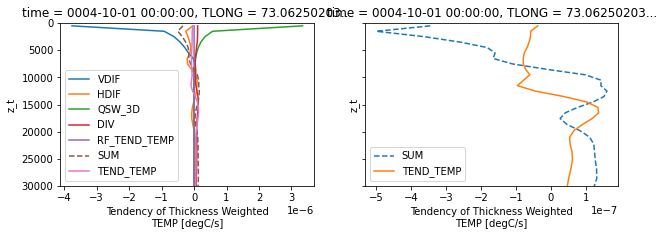

In [129]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), sharey=True)

# plot individual components
subset.VDIF.plot(y="z_t", ylim=(300e2, 0), label="VDIF", ax=ax[0])
subset.HDIF.plot(y="z_t", ylim=(300e2, 0), label="HDIF", ax=ax[0])
subset.QSW_3D.plot(y="z_t", ylim=(300e2, 0), label="QSW_3D", ax=ax[0])
subset.TOT_ADV.plot(y="z_t", ylim=(300e2, 0), label="DIV", ax=ax[0])
subset.RF_TEND_TEMP.plot(y="z_t", ylim=(300e2, 0), label="RF_TEND_TEMP", ax=ax[0])

# plot sum
(subset.QSW_3D + subset.HDIF + subset.VDIF + subset.TOT_ADV + subset.RF_TEND_TEMP).plot(
    y="z_t", ylim=(300e2, 0), label="SUM", ls="--", ax=ax[0]
)
# plot tendency
subset.TEND_TEMP.plot(y="z_t", ylim=(300e2, 0), label="TEND_TEMP", ax=ax[0])

ax[0].legend()

# plot sum
(subset.QSW_3D + subset.HDIF + subset.VDIF + subset.TOT_ADV + subset.RF_TEND_TEMP).plot(
    y="z_t", ylim=(300e2, 0), label="SUM", ls="--", ax=ax[1]
)
# plot tendency
subset.TEND_TEMP.plot(y="z_t", ylim=(300e2, 0), label="TEND_TEMP", ax=ax[1])

ax[1].legend();

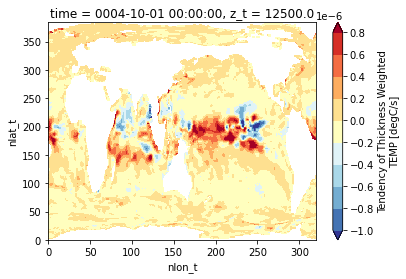

In [130]:
# plot maps
budget.TEND_TEMP.isel(z_t=12).plot(levels=np.arange(-1e-6,1e-6,2e-7),cmap="RdYlBu_r")

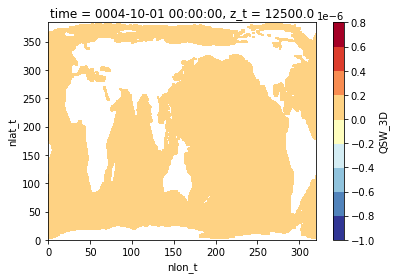

In [131]:
budget.QSW_3D.isel(z_t=12).plot(levels=np.arange(-1e-6,1e-6,2e-7),cmap="RdYlBu_r")

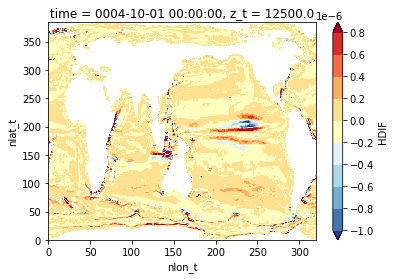

In [132]:
budget.HDIF.isel(z_t=12).plot(levels=np.arange(-1e-6,1e-6,2e-7),cmap="RdYlBu_r")

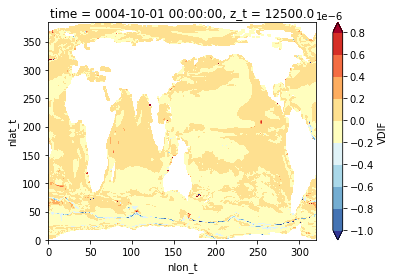

In [133]:
budget.VDIF.isel(z_t=12).plot(levels=np.arange(-1e-6,1e-6,2e-7),cmap="RdYlBu_r")

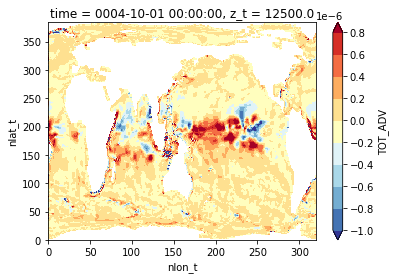

In [134]:
budget.TOT_ADV.isel(z_t=12).plot(levels=np.arange(-1e-6,1e-6,2e-7),cmap="RdYlBu_r")

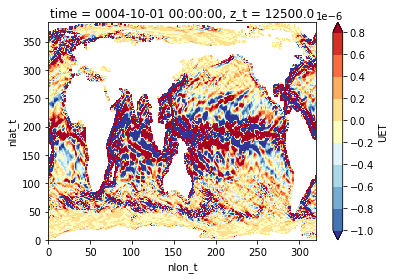

In [135]:
budget.UET.isel(z_t=12).plot(levels=np.arange(-1e-6,1e-6,2e-7),cmap="RdYlBu_r")

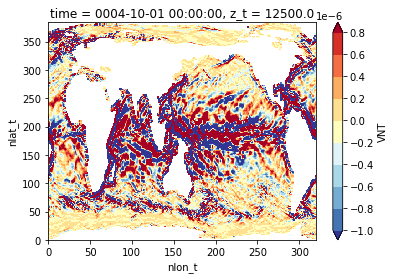

In [136]:
budget.VNT.isel(z_t=12).plot(levels=np.arange(-1e-6,1e-6,2e-7),cmap="RdYlBu_r")

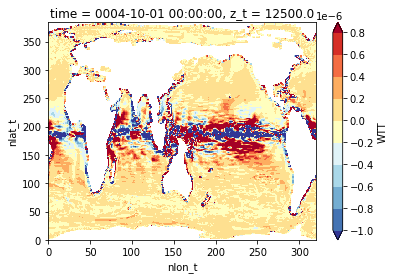

In [137]:
budget.WTT.isel(z_t=12).plot(levels=np.arange(-1e-6,1e-6,2e-7),cmap="RdYlBu_r")

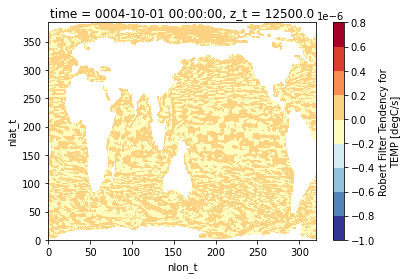

In [138]:
budget.RF_TEND_TEMP.isel(z_t=12).plot(levels=np.arange(-1e-6,1e-6,2e-7),cmap="RdYlBu_r")